In [16]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from classification import *
from xgboost_classifier import *
from testaccuracy import *

In [17]:
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [18]:
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='textModel_win=30_no_outside'

In [19]:
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [20]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [21]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/textModel_win=30_no_outside


In [22]:
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [23]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([-0.17289065, -3.8296752 ,  0.06695388,  3.82798338, -0.2867583 ,
       -0.6928432 ,  2.93742371,  2.01823235, -0.32684457, -1.44869399,
        0.27529755, -0.79016078,  1.79306448,  4.28960419,  0.13605687,
       -2.43463802,  0.09181995, -0.04406718,  2.46003342,  4.73867655,
        1.97732508,  2.34663606, -0.11793029, -3.57738924, -0.45679718,
       -3.54198337,  4.34884214,  2.30379629,  4.62182856,  2.40693569,
        1.11229527,  1.03004909, -0.47451738, -1.17208731, -1.95631719,
        0.94235301, -1.72339058,  0.94970924,  1.68300402,  5.48246861,
       -2.90595341,  2.47609782,  2.60338545, -0.22896838,  0.26752338,
        0.79036963, -1.86278892,  1.52235138, -0.40399107, -3.93441987,
       -0.16414452,  3.76050663, -0.12991294,  1.8676033 , -4.16120958,
        1.54574025, -2.70265174,  0.9447946 , -0.35614172,  0.77467412,
        0.18951511, -3.21754813,  1.22369778, -4.41033459,  1.06871235,
       -2.62220693, -1.1595726 , -0.85579103, -4.74306965,  0.44

In [24]:
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [25]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [26]:
# this is the 4 layer full-connected nerual network model
model = nn_baseline_model(TEXT_INPUT_DIM, GENE_INPUT_DIM, GENE_INPUT_DIM)
model.summary()

C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu", input_dim=250)`
  model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu")`
  model.add(Dense(256, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, kernel_initializer="normal", activation="relu")`
  model.add(Dense(80, init='normal', activation='relu'))
C:\Users\zhuya\Desktop\semester 1\249 data structure\project\src\src\classification.py:33: UserWarning: Update your `De

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               64256     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 729       
Total params: 151,337
Trainable params: 151,337
Non-trainable params: 0
_________________________________________________________________


begin training

Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 18s - loss: 2.3516 - acc: 0.04 - ETA: 2s - loss: 2.2778 - acc: 0.0781 - ETA: 0s - loss: 2.1990 - acc: 0.136 - ETA: 0s - loss: 2.1504 - acc: 0.171 - ETA: 0s - loss: 2.0840 - acc: 0.210 - ETA: 0s - loss: 2.0516 - acc: 0.224 - 0s - loss: 2.0413 - acc: 0.2257 - val_loss: 1.7783 - val_acc: 0.3889
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 1.9513 - acc: 0.281 - ETA: 0s - loss: 1.8750 - acc: 0.286 - ETA: 0s - loss: 1.8539 - acc: 0.291 - ETA: 0s - loss: 1.8510 - acc: 0.299 - ETA: 0s - loss: 1.8377 - acc: 0.302 - 0s - loss: 1.8314 - acc: 0.3063 - val_loss: 1.6857 - val_acc: 0.4173
Training accuracy: 30.63% / Best validation accuracy: 41.73%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 1.7511 - acc: 0.312 - ETA: 0s - loss: 1.7085 - acc: 0.365 - ETA: 0s - loss: 1.7216 - acc: 0

2951/2951 [==============================] - ETA: 0s - loss: 1.0871 - acc: 0.671 - ETA: 0s - loss: 1.0570 - acc: 0.631 - ETA: 0s - loss: 1.0861 - acc: 0.616 - ETA: 0s - loss: 1.1084 - acc: 0.603 - ETA: 0s - loss: 1.0960 - acc: 0.614 - ETA: 0s - loss: 1.0846 - acc: 0.620 - ETA: 0s - loss: 1.0862 - acc: 0.620 - 0s - loss: 1.0870 - acc: 0.6201 - val_loss: 1.4288 - val_acc: 0.5149
Training accuracy: 62.01% / Best validation accuracy: 51.49%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 1.0666 - acc: 0.640 - ETA: 0s - loss: 1.0223 - acc: 0.644 - ETA: 0s - loss: 1.0692 - acc: 0.634 - ETA: 0s - loss: 1.0700 - acc: 0.629 - ETA: 0s - loss: 1.0705 - acc: 0.632 - ETA: 0s - loss: 1.0814 - acc: 0.626 - 0s - loss: 1.0788 - acc: 0.6269 - val_loss: 1.4308 - val_acc: 0.5054
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.9146 - acc: 0.625 - ETA: 0s - loss: 1.0272 - acc: 0.628 - ETA: 0s - loss: 1.0215 - acc:

2951/2951 [==============================] - ETA: 0s - loss: 0.9147 - acc: 0.703 - ETA: 0s - loss: 0.7785 - acc: 0.738 - ETA: 0s - loss: 0.8098 - acc: 0.728 - ETA: 0s - loss: 0.8090 - acc: 0.716 - ETA: 0s - loss: 0.7978 - acc: 0.713 - ETA: 0s - loss: 0.7985 - acc: 0.708 - 0s - loss: 0.7981 - acc: 0.7086 - val_loss: 1.5491 - val_acc: 0.5136
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.8126 - acc: 0.671 - ETA: 0s - loss: 0.7602 - acc: 0.723 - ETA: 0s - loss: 0.7907 - acc: 0.717 - ETA: 0s - loss: 0.7676 - acc: 0.726 - ETA: 0s - loss: 0.7883 - acc: 0.719 - ETA: 0s - loss: 0.7833 - acc: 0.720 - 0s - loss: 0.7824 - acc: 0.7204 - val_loss: 1.6408 - val_acc: 0.5054
Training accuracy: 72.04% / Best validation accuracy: 51.49%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.9728 - acc: 0.687 - ETA: 0s - loss: 0.8165 - acc: 0.715 - ETA: 0s - loss: 0.7860 - acc: 0.716 - ETA: 0s - loss: 0.7891 - acc:

2951/2951 [==============================] - ETA: 0s - loss: 0.5935 - acc: 0.781 - ETA: 0s - loss: 0.6171 - acc: 0.770 - ETA: 0s - loss: 0.6048 - acc: 0.774 - ETA: 0s - loss: 0.5910 - acc: 0.784 - ETA: 0s - loss: 0.6112 - acc: 0.776 - ETA: 0s - loss: 0.6191 - acc: 0.778 - 0s - loss: 0.6292 - acc: 0.7750 - val_loss: 1.7657 - val_acc: 0.4878
Training accuracy: 77.50% / Best validation accuracy: 52.17%
Train on 2951 samples, validate on 738 samples
Epoch 1/2
2951/2951 [==============================] - ETA: 0s - loss: 0.5694 - acc: 0.781 - ETA: 0s - loss: 0.6020 - acc: 0.771 - ETA: 0s - loss: 0.6250 - acc: 0.767 - ETA: 0s - loss: 0.6310 - acc: 0.764 - ETA: 0s - loss: 0.6162 - acc: 0.768 - 0s - loss: 0.6049 - acc: 0.7777 - val_loss: 1.7602 - val_acc: 0.5176
Epoch 2/2
2951/2951 [==============================] - ETA: 0s - loss: 0.5680 - acc: 0.765 - ETA: 0s - loss: 0.5535 - acc: 0.809 - ETA: 0s - loss: 0.5802 - acc: 0.796 - ETA: 0s - loss: 0.5793 - acc: 0.797 - ETA: 0s - loss: 0.5945 - acc:

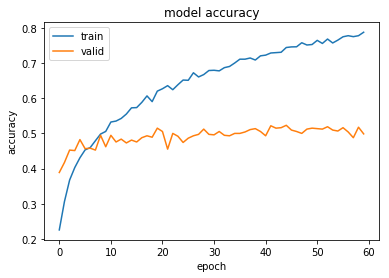

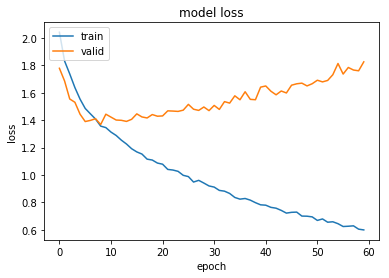

960/986 [============================>.] - ETA:  - ETA: 0s

In [27]:
model = train_nn_model(model, train_set, encoded_y, filename = 'try(win30)noload.h5')
y_predict = model.predict_proba(test_set)

In [32]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

In [ ]:
y_predict = xgbclassifier(train_set, train_y, test_set, 1, 8, 1000)

[0]	train-mlogloss:2.12142	valid-mlogloss:2.14445
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.12861	valid-mlogloss:1.47769
[50]	train-mlogloss:0.674425	valid-mlogloss:1.21393
[75]	train-mlogloss:0.434762	valid-mlogloss:1.09193


In [29]:
savesubmisstion(y_predict, test_x, filename = "submission_allwin30noload.csv")